In [111]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)

In [112]:
df = pd.read_csv("../Data/processed/dataset_clean.csv")

In [113]:
df.head()

,Temperature,Humidity,pH,Rainfall,Label,Category
0,20.879744,82.002744,6.502985,202.935536,Rice,Cereal
1,21.770462,80.319644,7.038096,226.655537,Rice,Cereal
2,23.004459,82.320763,7.840207,263.964248,Rice,Cereal
3,26.491096,80.158363,6.980401,242.864034,Rice,Cereal
4,20.130175,81.604873,7.628473,262.717340,Rice,Cereal


1. Definir para X variables predictoras y (etiqueta a predecir)
2. X contiene las características ambientales que explican el cultivo
3. Temperature, Humidity, pH y Rainfall
4. Y contiene la columna Label, que es el tipo de cultivo que queremos predecir

In [114]:
X = df[["Temperature", "Humidity", "pH", "Rainfall"]]
y = df["Label"]

In [115]:
X.head(), y.head()

(   Temperature   Humidity        pH    Rainfall
 0    20.879744  82.002744  6.502985  202.935536
 1    21.770462  80.319644  7.038096  226.655537
 2    23.004459  82.320763  7.840207  263.964248
 3    26.491096  80.158363  6.980401  242.864034
 4    20.130175  81.604873  7.628473  262.717340,
 0    Rice
 1    Rice
 2    Rice
 3    Rice
 4    Rice
 Name: Label, dtype: object)

1. Dividimos los datos en entrenamiento (80%) y prueba (20%)
2. Se usa stratify=y para mantener la misma proporción de cultivos en ambos conjuntos.
3. random_state=42 asegura que la división sea reproducible.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [117]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN ALGORITHM

In [118]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predicciones
knn_train_pred = knn.predict(X_train_scaled)
knn_test_pred = knn.predict(X_test_scaled)

# Accuracy train y test
knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)

print("KNN Modelo")
print("Accuracy en TRAIN:", knn_train_accuracy)
print("Accuracy en TEST:", knn_test_accuracy)
print(classification_report(y_test, knn_test_pred))

KNN Modelo
Accuracy en TRAIN: 0.9003571428571429
Accuracy en TEST: 0.8521428571428571
                  precision    recall  f1-score   support

        Aleovera       0.90      0.95      0.93        20
           Apple       0.86      0.95      0.90        20
        Arecanut       0.95      0.90      0.92        20
     Ashwagandha       1.00      1.00      1.00        20
           Bajra       1.00      1.00      1.00        20
          Banana       0.63      0.95      0.76        20
        Beetroot       0.91      1.00      0.95        20
       Blackgram       0.62      0.80      0.70        20
         Brinjal       0.79      0.75      0.77        20
        Broccoli       0.82      0.90      0.86        20
Button Mushrooms       0.50      0.45      0.47        20
         Cabbage       0.90      0.90      0.90        20
        Capsicum       0.87      1.00      0.93        20
          Carrot       0.95      1.00      0.98        20
      Cashewnuts       0.94      0.80      

El modelo KNN mostró un desempeño aceptable con una precisión de entrenamiento de 0.90 y de prueba de 0.85, lo que indica que no hay overfitting importante, pero su capacidad de generalización es menor que la de Random Forest. Funciona bien para muchas clases, alcanzando F1-scores altos, pero falla en clases con características similares o minoritarias, lo que genera confusiones y reduce la precisión global.

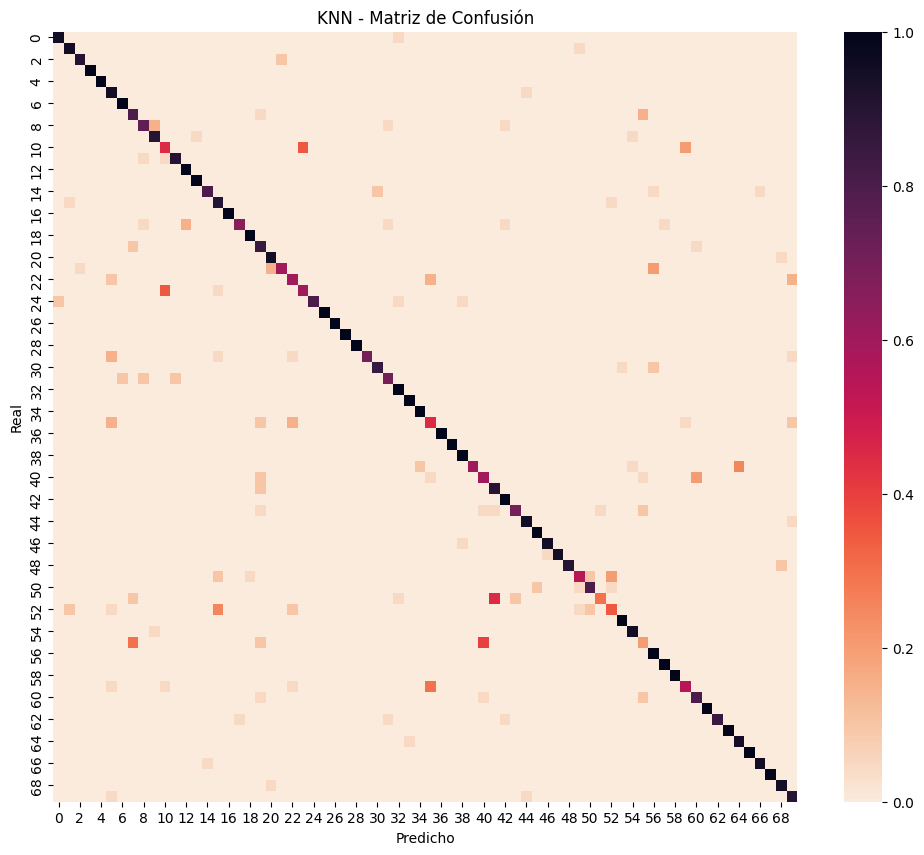

In [119]:
cm_knn = confusion_matrix(y_test, knn_test_pred, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, cmap="rocket_r")
plt.title("KNN - Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

1. n_estimators=200 mejora la estabilidad y precisión del modelo. No requiere escalado.
2. Random Forest no requiere de escalado 

In [120]:
cm = confusion_matrix(y_test, knn_test_pred)
errors = cm.copy()
np.fill_diagonal(errors, 0)

idx = np.dstack(np.unravel_index(np.argsort(errors.ravel())[-10:], errors.shape))[0]

print("Top 10 confusiones del modelo KNN:")
for real, pred in idx[::-1]:
    print(f"Real {real} → Predicho {pred}: {errors[real, pred]} veces")


Top 10 confusiones del modelo KNN:
Real 51 → Predicho 41: 9 veces
Real 55 → Predicho 40: 8 veces
Real 23 → Predicho 10: 7 veces
Real 10 → Predicho 23: 7 veces
Real 55 → Predicho 7: 6 veces
Real 59 → Predicho 35: 6 veces
Real 39 → Predicho 64: 5 veces
Real 52 → Predicho 15: 5 veces
Real 40 → Predicho 60: 4 veces
Real 49 → Predicho 52: 4 veces


Se observa que ciertas clases se mezclan de forma consistente: por ejemplo, la clase 51 se confundió con la 41 nueve veces, la 55 con la 40 ocho veces, y la 23 con la 10 siete veces. Estas confusiones muestran que el modelo tiene dificultades para diferenciar algunas clases específicas, lo que afecta el desempeño global y señala la necesidad de mejorar la separación de características o de ajustar hiperparámetros como el número de vecinos k.

# Random Forest

In [121]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [122]:
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

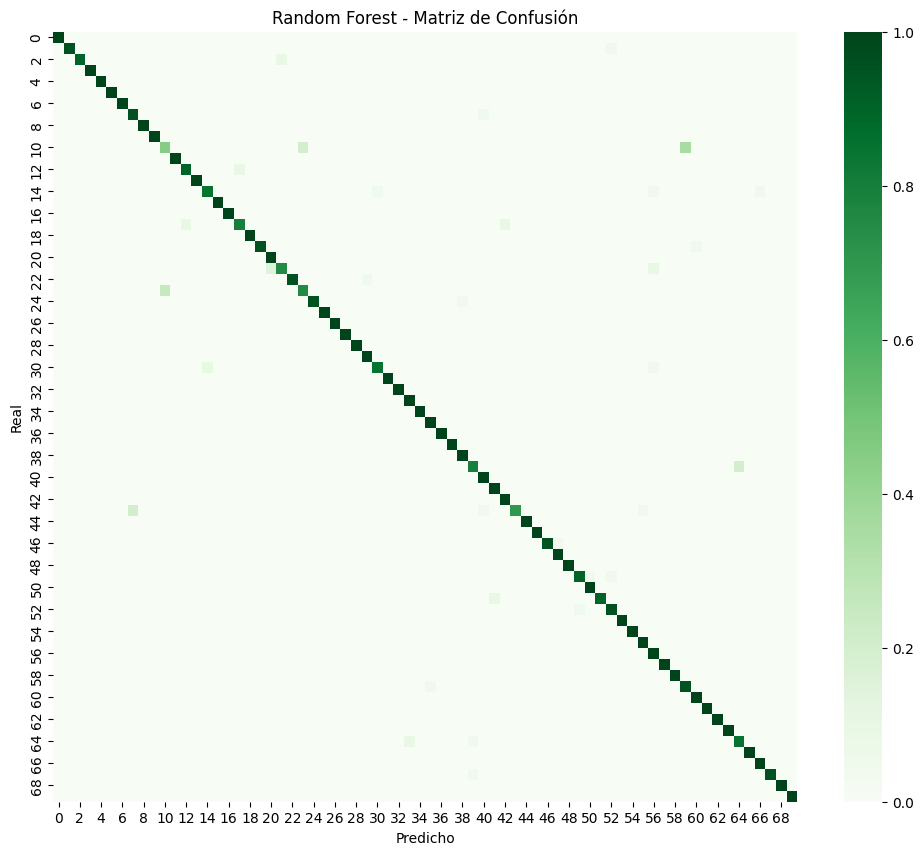

In [123]:
# Matriz de confusión
cm_rf = confusion_matrix(y_test, rf_test_pred, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm_rf, cmap="Greens")
plt.title("Random Forest - Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

El Random Forest demuestra una alta capacidad de generalización y robustez para este problema. Su desempeño se refleja en una matriz de confusión mas limpia, lo que respalda que sea el mejor modelo comparado con KNN

In [124]:

rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)

print("\n--- Random Forest Base ---")
print("Accuracy TRAIN:", rf_train_accuracy)
print("Accuracy TEST:", rf_test_accuracy)
print(classification_report(y_test, rf_test_pred))


--- Random Forest Base ---
Accuracy TRAIN: 1.0
Accuracy TEST: 0.9564285714285714
                  precision    recall  f1-score   support

        Aleovera       1.00      1.00      1.00        20
           Apple       1.00      0.95      0.97        20
        Arecanut       1.00      0.90      0.95        20
     Ashwagandha       1.00      1.00      1.00        20
           Bajra       1.00      1.00      1.00        20
          Banana       1.00      1.00      1.00        20
        Beetroot       1.00      1.00      1.00        20
       Blackgram       0.83      0.95      0.88        20
         Brinjal       1.00      1.00      1.00        20
        Broccoli       1.00      1.00      1.00        20
Button Mushrooms       0.64      0.45      0.53        20
         Cabbage       1.00      1.00      1.00        20
        Capsicum       0.90      0.90      0.90        20
          Carrot       1.00      1.00      1.00        20
      Cashewnuts       0.89      0.85      0.87

El modelo Random Forest base alcanza un accuracy global del 95.6% y un F1-score promedio de 0.96, mostrando un excelente desempeño general en la clasificación de cultivos. Sin embargo, algunas clases como Button Mushrooms, Rice y Sweet Potato presentan un menor F1-score, indicando confusiones con otras clases. Esto sugiere que se podrían explorar estrategias de balance de datos o ingeniería de características adicionales para mejorar la precisión en estas clases específicas

In [125]:
rf_base = RandomForestClassifier(random_state=42)

2. Malla de hiperparámetros

In [126]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

3. GridSearch usando LOS DATOS ESCALADOS

In [127]:
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    n_jobs=2,
    verbose=1
)

In [128]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True], 'max_depth': [None, 20], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,2
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


 4. Mostrar los mejores parámetros

In [129]:
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


5. Evaluar modelo optimizado


In [130]:
best_rf = grid_search.best_estimator_
best_rf_train_pred = best_rf.predict(X_train)
best_rf_test_pred = best_rf.predict(X_test)


best_rf_train_accuracy = accuracy_score(y_train, best_rf_train_pred)
best_rf_test_accuracy = accuracy_score(y_test, best_rf_test_pred)

print("\n--- Random Forest Optimizado ---")
print("Accuracy TRAIN:", best_rf_train_accuracy)
print("Accuracy TEST:", best_rf_test_accuracy)
print(classification_report(y_test, best_rf_test_pred))



--- Random Forest Optimizado ---
Accuracy TRAIN: 0.9969642857142857
Accuracy TEST: 0.9578571428571429
                  precision    recall  f1-score   support

        Aleovera       1.00      1.00      1.00        20
           Apple       1.00      0.95      0.97        20
        Arecanut       1.00      0.90      0.95        20
     Ashwagandha       1.00      1.00      1.00        20
           Bajra       1.00      1.00      1.00        20
          Banana       1.00      1.00      1.00        20
        Beetroot       1.00      1.00      1.00        20
       Blackgram       0.86      0.95      0.90        20
         Brinjal       1.00      1.00      1.00        20
        Broccoli       1.00      1.00      1.00        20
Button Mushrooms       0.69      0.45      0.55        20
         Cabbage       1.00      1.00      1.00        20
        Capsicum       0.90      0.90      0.90        20
          Carrot       1.00      1.00      1.00        20
      Cashewnuts       1.0

La optimización redujo ligeramente el overfitting y mejoró la precisión de algunas clases menores, pero las clases más difíciles (Button Mushrooms, Mothbeans, Rice, Sweet Potato) todavía presentan confusiones. Esto sugiere que se podrían explorar estrategias adicionales, como aumento de datos o ingeniería de características específicas para estas clases, para lograr mejoras adicionales.

 6. Mejor score de validación cruzada

In [131]:
print("\nMejor accuracy durante la validación cruzada:", grid_search.best_score_)


Mejor accuracy durante la validación cruzada: 0.9623219364632675


C:\Users\braya\AppData\Local\Temp\ipykernel_21192\1589557179.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc, y=model, palette='viridis')


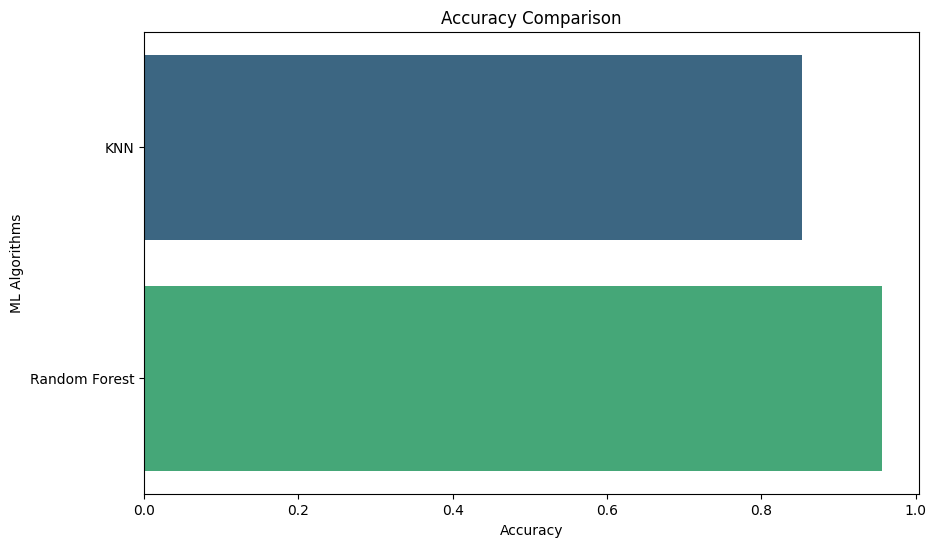

In [132]:
model = ['KNN', 'Random Forest']
acc = [knn_test_accuracy, rf_test_accuracy]

plt.figure(figsize=(10, 6), dpi=100, facecolor='white')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('ML Algorithms')
sns.barplot(x=acc, y=model, palette='viridis')
plt.show()

Random Forest supera a KNN en accuracy general, mostrando mejor rendimiento global en el conjunto de prueba. Esto sugiere que Random Forest es más robusto para este dataset

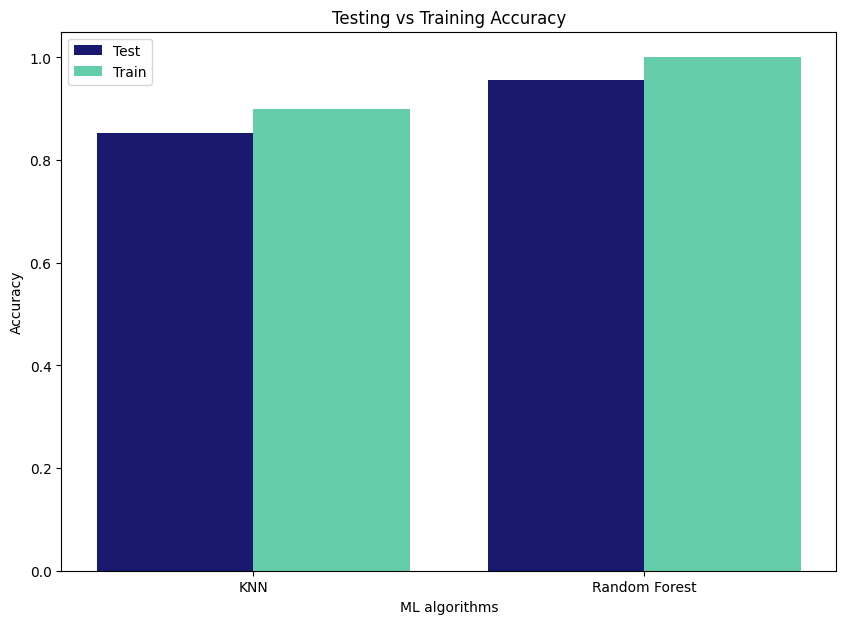

In [133]:
label = ['KNN','Random Forest']
Test = [knn_test_accuracy,rf_test_accuracy]
Train = [knn_train_accuracy,rf_train_accuracy]

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)
X_axis = np.arange(len(label))
plt.bar(X_axis - 0.2,Test, 0.4, label = 'Test', color=('midnightblue'))
plt.bar(X_axis + 0.2,Train, 0.4, label = 'Train', color=('mediumaquamarine'))

plt.xticks(X_axis, label)
plt.xlabel("ML algorithms")
plt.ylabel("Accuracy")
plt.title("Testing vs Training Accuracy")
plt.legend()
plt.show()

Random Forest muestra un patrón casi completamente diagonal, lo cual indica que el modelo clasifica correctamente la gran mayoría de las observaciones. La diagonal dominante, con valores normalizados cercanos a 1, significa que el modelo acierta consistentemente en cada una de las clases del conjunto de datos.

KNN muestra un comportamiento estable sin sobreajuste. Random Forest presenta un pequeño sobreajuste pero mantiene excelente precisión en prueba. Aun con ese detalle, sigue siendo el mejor modelo en general.